In [1]:
import logging
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from recommenders.utils.python_utils import binarize
from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    rmse,
    mae,
    logloss,
    rsquared,
    exp_var,
    auc,
    confusion_matrix
)
from recommenders.models.sar import SAR
import sys

In [2]:
def load_df(size="1"):
  if(size==5):
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_1.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
    for i in range(2,5):
      df_temp = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{i}.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
      df.append(df_temp)
  else:
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{size}.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
  df.index = np.arange(0,len(df))
  df_nan = pd.DataFrame(pd.isnull(df.rating))
  df_nan = df_nan[df_nan['rating'] == True]
  df_nan = df_nan.reset_index()
  movie_np = []
  movie_id = 1
  for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
      temp = np.full((1,i-j-1), movie_id)
      movie_np = np.append(movie_np, temp)
      movie_id += 1
  last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
  movie_np = np.append(movie_np, last_record)
  df = df[pd.notnull(df['rating'])]
  df['itemID'] = movie_np.astype(int)
  df['userID'] = df['userID'].astype(int)
  df['rating'] = df['rating'].astype(float)
  df = df[df["itemID"]<=1500]
  df = df[df["userID"]<=50000]
  return df

In [3]:
data = load_df()

In [4]:
data['rating'] = data['rating'].astype(np.float32)
data["timestamp"] = data["timestamp"].apply(lambda X : X.replace('-', ''))
data['timestamp'] = data['timestamp'].astype(np.int64)
# type(data.timestamp[4])
train, test = python_stratified_split(data, ratio=0.75, col_user='userID', col_item='itemID', seed=42)

In [5]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [6]:
print("""
Train:
Total Ratings: {train_total}
Unique Users: {train_users}
Unique Items: {train_items}

Test:
Total Ratings: {test_total}
Unique Users: {test_users}
Unique Items: {test_items}
""".format(
    train_total=len(train),
    train_users=len(train['userID'].unique()),
    train_items=len(train['itemID'].unique()),
    test_total=len(test),
    test_users=len(test['userID'].unique()),
    test_items=len(test['itemID'].unique()),
))


Train:
Total Ratings: 106279
Unique Users: 8169
Unique Items: 1410

Test:
Total Ratings: 34860
Unique Users: 6590
Unique Items: 1151



In [7]:
logging.basicConfig(level=logging.DEBUG, 
                    format='%(asctime)s %(levelname)-8s %(message)s')

model = SAR(
    col_user="userID",
    col_item="itemID",
    col_rating="rating",
    col_timestamp="timestamp",
    similarity_type="jaccard", 
    time_decay_coefficient=30, 
    timedecay_formula=True,
    normalize=True
)

In [8]:
with Timer() as train_time:
    model.fit(train)

print("Took {} seconds for training.".format(train_time.interval))

2023-01-10 11:38:28,803 INFO     Collecting user affinity matrix
2023-01-10 11:38:28,803 INFO     Calculating time-decayed affinities
2023-01-10 11:38:28,819 INFO     Creating index columns
2023-01-10 11:38:28,881 INFO     Calculating normalization factors
2023-01-10 11:38:28,912 INFO     Building user affinity sparse matrix
2023-01-10 11:38:28,912 INFO     Calculating item co-occurrence


20051231
<class 'numpy.int64'> <class 'pandas.core.series.Series'>
20051231
<class 'numpy.int64'> <class 'pandas.core.series.Series'>


2023-01-10 11:38:28,959 INFO     Calculating item similarity
2023-01-10 11:38:28,959 INFO     Using jaccard based similarity
2023-01-10 11:38:28,991 INFO     Done training


Took 0.21112109999999973 seconds for training.


In [9]:
with Timer() as test_time:
    top_k = model.recommend_k_items(test, top_k=10, remove_seen=True)

print("Took {} seconds for prediction.".format(test_time.interval))

2023-01-10 11:38:29,006 INFO     Calculating recommendation scores
2023-01-10 11:38:29,287 INFO     Removing seen items


Took 0.6394395000000088 seconds for prediction.


In [10]:
top_k.head()

,userID,itemID,prediction
0,6,607,3.316523
1,6,798,3.207483
2,6,571,3.188252
3,6,1102,3.115282
4,6,329,3.080248


In [11]:
TOP_K=10

In [12]:
eval_map = map_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_ndcg = ndcg_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_precision = precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_recall = recall_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_rmse = rmse(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
eval_mae = mae(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
eval_rsquared = rsquared(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
eval_exp_var = exp_var(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
# eval_auc = auc(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')

In [13]:
positivity_threshold = 2
test_bin = test.copy()
test_bin['rating'] = binarize(test_bin['rating'], positivity_threshold)

top_k_prob = top_k.copy()
top_k_prob['prediction'] = minmax_scale(
    top_k_prob['prediction'].astype(float)
)

eval_logloss = logloss(test_bin, top_k_prob, col_user='userID', col_item='itemID', col_rating='rating')

In [14]:
top_k_prob.head(),test_bin.head()

(   userID  itemID  prediction
 0       6     607    0.649696
 1       6     798    0.618075
 2       6     571    0.612499
 3       6    1102    0.591338
 4       6     329    0.581179,
          userID  rating  timestamp  itemID
 7315294       6     1.0   20040922    1467
 7432799       6     0.0   20050829    1476
 1723707       6     1.0   20040915     329
 6311835       6     1.0   20041207    1220
 2886520       6     1.0   20051026     528)

In [15]:
print("Model:\t",
      "Top K:\t%d" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall,
      "RMSE:\t%f" %eval_rmse,
      "MAE:\t%f" %eval_mae,
      "RSquared:\t%f" %eval_rsquared,
      "Exp_Var:\t%f" %eval_exp_var,
      "Logloss:\t%f" % eval_logloss,
      sep='\n')

Model:	
Top K:	10
MAP:	0.138327
NDCG:	0.250393
Precision@K:	0.143475
Recall@K:	0.292674
RMSE:	1.262606
MAE:	1.043910
RSquared:	-0.664870
Exp_Var:	-0.063798
Logloss:	0.604564


In [2]:
conf_mat = confusion_matrix('model','test',"SAR")

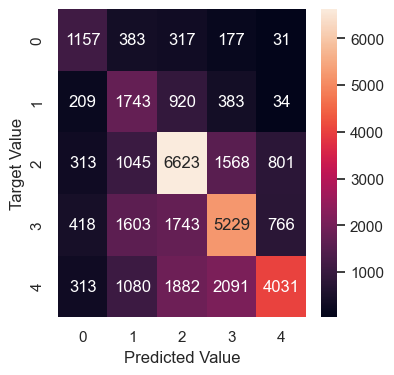

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(4,4)})
sns.heatmap(conf_mat,fmt='',annot=True)
plt.xlabel("Predicted Value")
plt.ylabel("Target Value")
plt.show()